In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

print("Imports completados")

# Cargar datos de Fase 1
print("\nCargando datos consolidados...")

df_overview_all = pd.read_parquet('../data/processed/overview_all_years.parquet')
df_scores_all   = pd.read_parquet('../data/processed/scores_all_years.parquet')

print(f"Overview: {len(df_overview_all):,} filas")
print(f"Scores: {len(df_scores_all):,} filas")

Imports completados

Cargando datos consolidados...
Overview: 1,113,055 filas
Scores: 12,334 filas


In [2]:
# Filtrar solo partidos completos (All Maps)
print("Filtrando solo All Maps...")

df_all_maps = df_overview_all[df_overview_all['Map'] == 'All Maps'].copy()

print(f"- Antes:  {len(df_overview_all):,} filas")
print(f"- Después: {len(df_all_maps):,} filas")

# Filtramos solo side = both para obtener las stats completas de los partidos

print("\nFiltrando por Side = 'both'")
print(f"Valores únicos en Side: {df_all_maps['Side'].unique()}")

# Filtrar por side = both
df_filtered = df_all_maps[df_all_maps['Side'] == 'both'].copy()

print("\nResultado:")
print(f"   • Antes:  {len(df_all_maps):,} filas")   # ← df_all_maps (antes del filtro)
print(f"   • Después: {len(df_filtered):,} filas")   # ← df_filtered (después del filtro)

print(f"\nPrimeras 5 filas:")
display(df_filtered[['Match Name', 'Player', 'Team', 'Kills', 'Deaths', 'Average Combat Score']].head(5))

Filtrando solo All Maps...
- Antes:  1,113,055 filas
- Después: 320,439 filas

Filtrando por Side = 'both'
Valores únicos en Side: ['both' 'attack' 'defend']

Resultado:
   • Antes:  320,439 filas
   • Después: 106,813 filas

Primeras 5 filas:


,Match Name,Player,Team,Kills,Deaths,Average Combat Score
30,Vision Strikers vs FULL SENSE,BuZz,Vision Strikers,40.0,21.0,286.0
33,Vision Strikers vs FULL SENSE,Rb,Vision Strikers,26.0,16.0,200.0
36,Vision Strikers vs FULL SENSE,MaKo,Vision Strikers,22.0,18.0,178.0
39,Vision Strikers vs FULL SENSE,k1Ng,Vision Strikers,31.0,24.0,253.0
42,Vision Strikers vs FULL SENSE,stax,Vision Strikers,26.0,25.0,172.0


1. Filtrar solo "All Maps" o agregar mapas individuales
2. Sumar stats de 5 jugadores → 1 equipo
3. Crear formato: Team A vs Team B (una fila por partido/mapa)
4. Añadir variable objetivo: ¿Quién ganó?
5. Crear features diferenciales (Team A - Team B)

In [3]:
print("="*60)
print("Featuring Engineering")
print("="*60)

# Cargamos los datos previamente guardados
df_overview_all = pd.read_parquet('../data/processed/overview_all_years.parquet')
df_scores_all = pd.read_parquet('../data/processed/scores_all_years.parquet')

print(f"Overview: {len(df_overview_all):,} filas")
print(f"Scores: {len(df_scores_all):,} filas")

print("\n Filtramos solo partidos completos")

df_all_maps = df_overview_all[df_overview_all['Map'] == 'All Maps'].copy()

print(f"\n Resultado del filtro:")
print(f"- Antes (todas las filas): {len(df_overview_all):,}")
print(f"- Después (solo All Maps): {len(df_all_maps):,}")
print(f"- Reducción: {(1 - len(df_all_maps)/len(df_overview_all))*100:.1f}%")

print(f"\nPrimeras 3 filas:")
display(df_all_maps[['year', 'Match Name', 'Player', 'Team', 'Kills', 'Deaths', 'Average Combat Score']].head(3))

Featuring Engineering


Overview: 1,113,055 filas
Scores: 12,334 filas

 Filtramos solo partidos completos

 Resultado del filtro:
- Antes (todas las filas): 1,113,055
- Después (solo All Maps): 320,439
- Reducción: 71.2%

Primeras 3 filas:


,year,Match Name,Player,Team,Kills,Deaths,Average Combat Score
30,2021,Vision Strikers vs FULL SENSE,BuZz,Vision Strikers,40.0,21.0,286.0
31,2021,Vision Strikers vs FULL SENSE,BuZz,Vision Strikers,25.0,13.0,283.0
32,2021,Vision Strikers vs FULL SENSE,BuZz,Vision Strikers,15.0,8.0,293.0


TRANSFORMACIÓN:
De: 10 filas (1 por jugador)
A:   2 filas (1 por equipo)

OPERACIONES:
- Kills/Deaths/Assists → SUMAR (totales del equipo)
- ACS/Rating → PROMEDIAR (promedio del equipo)

In [4]:


# Agregamos stats de jugadores a nivel de equipo
print("Agrupando jugadores -> equipos")
print("="*60)

group_cols = ['Match Name', 'Team', 'year']
agg_dict = {
    'Kills': 'sum',                      # Kills totales
    'Deaths': 'sum',                     # Deaths totales
    'Assists': 'sum',                    # Assists totales
    'Average Combat Score': 'mean',      # ACS promedio
    'Rating': 'mean',                    # Rating promedio
    'First Kills': 'sum',                # First Kills totales
    'First Deaths': 'sum'                # First Deaths totales
}

print("Realizando agregación...")


df_team_stats = df_filtered.groupby(group_cols).agg(agg_dict).reset_index()

print("\n Agregación completada")
print("\n Resultado:")
print(f"- Antes: {len(df_filtered):,} filas")
print(f"- Despues: {len(df_team_stats):,} filas")
print(f"- Reducción: {(1 - len(df_team_stats)/len(df_filtered))*100:.1f}%")

print("\n Creando features derivadas...")
df_team_stats['KD_Ratio'] = df_team_stats['Kills'] / df_team_stats['Deaths'].replace(0, 1)
df_team_stats['KA_Ratio'] = (df_team_stats['Kills'] + df_team_stats['Assists']) / df_team_stats['Deaths'].replace(0, 1)
df_team_stats['FK_FD_Diff'] = df_team_stats['First Kills'] - df_team_stats['First Deaths']

print(f"\nPrimeras 5 filas")
display(df_team_stats[['Match Name', 'Team', 'Kills', 'Deaths', 'Average Combat Score', 'KD_Ratio']].head())

print(f"\nEstadísticas:")
display(df_team_stats[['Kills', 'Deaths', 'Average Combat Score', 'Rating', 'KD_Ratio']].describe())

Agrupando jugadores -> equipos
Realizando agregación...

 Agregación completada

 Resultado:
- Antes: 106,813 filas
- Despues: 19,132 filas
- Reducción: 82.1%

 Creando features derivadas...

Primeras 5 filas


,Match Name,Team,Kills,Deaths,Average Combat Score,KD_Ratio
0,#1 Victory Royale vs Karasuno,#1 Victory Royale,138.0,72.0,257.8,1.916667
1,+W party vs tyeasy,+W party,113.0,156.0,172.6,0.724359
2,+W party vs tyeasy,tyeasy,156.0,113.0,215.4,1.380531
3,01234 vs Sluper,1234,132.0,29.0,259.0,4.551724
4,01234 vs Sluper,Sluper,29.0,132.0,82.0,0.219697



Estadísticas:


,Kills,Deaths,Average Combat Score,Rating,KD_Ratio
count,19132.000000,19132.000000,19128.000000,15291.000000,19132.000000
mean,185.692296,185.578769,201.972239,0.989659,1.064357
std,101.623525,101.796522,27.760966,0.230668,0.394667
min,0.000000,0.000000,63.200000,0.223333,0.000000
25%,135.000000,134.000000,184.400000,0.830000,0.805415
50%,161.000000,161.000000,203.400000,0.991000,1.000000
75%,219.000000,219.000000,221.915000,1.150000,1.243540
max,1387.000000,1388.000000,274.400000,1.758000,6.736842


In [5]:
"""
Paso 4: Verificar que cada partido tiene 2 equipos
"""

print("Verificación de estructura")
print("=" * 60)

# Contar partidos únicos
unique_matches = df_team_stats['Match Name'].nunique()
print(f"\nPartidos únicos: {unique_matches:,}")

# Verificar equipos por partido
teams_per_match = df_team_stats.groupby('Match Name').size()

print(f"\nDistribución de equipos por partido:")
print(f"- Partidos con 1 equipo: {(teams_per_match == 1).sum():,}")
print(f"- Partidos con 2 equipos: {(teams_per_match == 2).sum():,}")
print(f"- Partidos con 3+ equipos: {(teams_per_match > 2).sum():,}")

# ¿Cuántos partidos tienen exactamente 2 equipos?
valid_matches = (teams_per_match == 2).sum()
total_matches = len(teams_per_match)

print(f"\nResumen:")
print(f"- Partidos válidos (2 equipos): {valid_matches:,} ({valid_matches/total_matches*100:.1f}%)")
print(f"- Partidos inválidos: {total_matches - valid_matches:,}")

# Ver un ejemplo
print(f"\nEJEMPLO: Un partido completo")
print("=" * 60)

first_match = df_team_stats['Match Name'].iloc[0]
match_data = df_team_stats[df_team_stats['Match Name'] == first_match]

print(f"\nPartido: {first_match}")
print(f"Equipos involucrados: {match_data['Team'].tolist()}")

display(match_data[['Team', 'Kills', 'Deaths', 'Average Combat Score', 'KD_Ratio']])

Verificación de estructura

Partidos únicos: 9,077

Distribución de equipos por partido:
- Partidos con 1 equipo: 46
- Partidos con 2 equipos: 8,617
- Partidos con 3+ equipos: 414

Resumen:
- Partidos válidos (2 equipos): 8,617 (94.9%)
- Partidos inválidos: 460

EJEMPLO: Un partido completo

Partido: #1 Victory Royale vs Karasuno
Equipos involucrados: ['#1 Victory Royale']


,Team,Kills,Deaths,Average Combat Score,KD_Ratio
0,#1 Victory Royale,138.0,72.0,257.8,1.916667


In [6]:
# Filtrar solo partidos con exactamente 2 equipos

print("Filtrando partidos válidos")
print("="*60)

teams_per_match = df_team_stats.groupby('Match Name').size()
valid_match_names = teams_per_match[teams_per_match == 2].index

print(f"\n Paridos válidos identificados: {len(valid_match_names):,}")

# Filtrar el DataFrame
df_team_stats_valid = df_team_stats[df_team_stats['Match Name'].isin(valid_match_names)].copy()

print("\n Filtrado completado")
print(f"- Antes: {len(df_team_stats):,} filas ({df_team_stats['Match Name'].nunique():,} partidos)")
print(f"- Partidos descartados: {df_team_stats['Match Name'].nunique() - df_team_stats_valid['Match Name'].nunique():,}")

# Verificar
teams_check = df_team_stats_valid.groupby('Match Name').size()
print(f"\nVerificación")
print(f"- Todos los partidos tienen 2 equipos: {(teams_check == 2).all()}")

# Ver ejemplo
print(f"\nEjemplo: Primer partido válido")
print("=" * 60)

first_match = df_team_stats_valid['Match Name'].iloc[0]
match_data = df_team_stats_valid[df_team_stats_valid['Match Name'] == first_match]

print(f"\nPartido: {first_match}")
display(match_data[['Team', 'Kills', 'Deaths', 'Average Combat Score', 'KD_Ratio']])

Filtrando partidos válidos

 Paridos válidos identificados: 8,617

 Filtrado completado
- Antes: 19,132 filas (9,077 partidos)
- Partidos descartados: 460

Verificación
- Todos los partidos tienen 2 equipos: True

Ejemplo: Primer partido válido

Partido: +W party vs tyeasy


,Team,Kills,Deaths,Average Combat Score,KD_Ratio
1,+W party,113.0,156.0,172.6,0.724359
2,tyeasy,156.0,113.0,215.4,1.380531


OBJETIVO:
De esto:
   Match Name | Team A  | Kills: 200
   Match Name | Team B  | Kills: 180

A esto:
   Match Name | teamA: Team A | teamA_kills: 200 | teamB: Team B | teamB_kills: 180

In [7]:
# Transformamos a formato Team A vs Team B
print(" Transformando a formato team A vs team B")
print("="*60)
print("\n Separando equipos....")

def split_teams(group):
    teams = sorted(group['Team'].unique())

    if len(teams) != 2:
        return None

    team_a_data = group[group['Team'] == teams[0]].iloc[0]
    team_b_data = group[group['Team'] == teams[1]].iloc[0]

    return team_a_data, team_b_data


teamA_rows = []
teamB_rows = []

for match_name, group in df_team_stats_valid.groupby('Match Name'):
    result = split_teams(group)
    if result:
        team_a, team_b = result
        teamA_rows.append(team_a)
        teamB_rows.append(team_b)

df_teamA = pd.DataFrame(teamA_rows)
df_teamB = pd.DataFrame(teamB_rows)

print(f"Team A: {len(df_teamA):,} filas")
print(f"Team B: {len(df_teamB):,} filas")


print("\n Renombrando columnas...")

# Para Team A
teamA_rename = {
    'Team': 'teamA_name',
    'Kills': 'teamA_kills',
    'Deaths': 'teamA_deaths',
    'Assists': 'teamA_assists',
    'Average Combat Score': 'teamA_acs',
    'Rating': 'teamA_rating',
    'First Kills': 'teamA_first_kills',
    'First Deaths': 'teamA_first_deaths',
    'KD_Ratio': 'teamA_kd',
    'KA_Ratio': 'teamA_ka',
    'FK_FD_Diff': 'teamA_fkfd_diff'
}

df_teamA = df_teamA.rename(columns = teamA_rename)

# Para Team B
teamB_rename = {k: v.replace('teamA', 'teamB') for k, v in teamA_rename.items()}
df_teamB = df_teamB.rename(columns = teamB_rename)

print("\n Uniendo Team A y Team B...")
df_wide = df_teamA.merge(
    df_teamB,
    on=['Match Name', 'year'],
    how='inner'
)

print("\n Transformación completa")
print("\n Dataset final:")
print(f"- Filas: {len(df_wide):,}")
print(f"- Columnas: {df_wide.shape[1]}")

print(f"\nPrimeras 3 filas:")
display(df_wide[['Match Name', 'teamA_name', 'teamA_kills', 'teamB_name', 'teamB_kills']].head(3))

print(f"\nColumnas disponibles:")
for i, col in enumerate(df_wide.columns, 1):
    print(f"   {i}. {col}")

 Transformando a formato team A vs team B

 Separando equipos....
Team A: 8,617 filas
Team B: 8,617 filas

 Renombrando columnas...

 Uniendo Team A y Team B...

 Transformación completa

 Dataset final:
- Filas: 8,617
- Columnas: 24

Primeras 3 filas:


,Match Name,teamA_name,teamA_kills,teamB_name,teamB_kills
0,+W party vs tyeasy,+W party,113.0,tyeasy,156.0
1,01234 vs Sluper,1234,132.0,Sluper,29.0
2,0Zero vs AlphaQ,0Zero,143.0,AlphaQ,63.0



Columnas disponibles:
   1. Match Name
   2. teamA_name
   3. year
   4. teamA_kills
   5. teamA_deaths
   6. teamA_assists
   7. teamA_acs
   8. teamA_rating
   9. teamA_first_kills
   10. teamA_first_deaths
   11. teamA_kd
   12. teamA_ka
   13. teamA_fkfd_diff
   14. teamB_name
   15. teamB_kills
   16. teamB_deaths
   17. teamB_assists
   18. teamB_acs
   19. teamB_rating
   20. teamB_first_kills
   21. teamB_first_deaths
   22. teamB_kd
   23. teamB_ka
   24. teamB_fkfd_diff


In [8]:
# Añadiendo información del ganador desde scores.csv
print("\n Haciendo JOIN con scores...")

df_wide_with_winner = df_wide.merge(
    df_scores_all[['Match Name', 'Team A', 'Team B', 'Match Result']],
    on = 'Match Name',
    how = 'left'
)

print("JOIN completado")
print(f"- Filas antes: {len(df_wide):,}")
print(f"- Filas despues: {len(df_wide_with_winner):,}")

# Ver si hay partidos sin información de ganador
missing_winner = df_wide_with_winner['Match Result'].isnull().sum()
print(f"- Partidos sin ganador: {missing_winner:,}")

if missing_winner > 0:
    print(f"\n{missing_winner} partidos no tienen información de ganador")
    print("Los descartaremos en el siguiente paso")
else:
    print("\Todos los partidos tienen información de ganador")

# Ver primeras filas
print(f"\nPrimeras 3 filas con ganador:")
display(df_wide_with_winner[['Match Name', 'teamA_name', 'teamB_name', 'Team A', 'Team B', 'Match Result']].head(5))



 Haciendo JOIN con scores...
JOIN completado
- Filas antes: 8,617
- Filas despues: 9,467
- Partidos sin ganador: 0
\Todos los partidos tienen información de ganador

Primeras 3 filas con ganador:


,Match Name,teamA_name,teamB_name,Team A,Team B,Match Result
0,+W party vs tyeasy,+W party,tyeasy,+W party,tyeasy,tyeasy won
1,01234 vs Sluper,1234,Sluper,01234,Sluper,01234 won
2,0Zero vs AlphaQ,0Zero,AlphaQ,0Zero,AlphaQ,0Zero won
3,0Zero vs Inertia,0Zero,Inertia,0Zero,Inertia,Inertia won
4,100 Thieves vs 2Game Esports,100 Thieves,2Game Esports,100 Thieves,2Game Esports,100 Thieves won


Tenemos que limpiar duplicados porque antes del join eran 8617 partidos y despues hay 9467 partidos por lo que pueden existir partidos duplicados.

Limpiando duplicados

 Filas duplicadas: 850

 Duplicados eliminados
- Antes: 9,467 filas
- Despues: 8,617 filas

 Creando variable objetivo

Verificación: 4,312/8,617 partidos tienen Team A == teamA_name

 Variable 'teamA_won' creada
- 1 = Team A ganó
- 0 = Team B ganó

 Distribución:
- Team A victorias: 4,433 (51.4%)
- Team B victorias: 4,184 (48.6%)

Dataset BALANCEADO

EJEMPLOS:


,Match Name,teamA_name,teamB_name,Match Result,teamA_won
0,+W party vs tyeasy,+W party,tyeasy,tyeasy won,0
1,01234 vs Sluper,1234,Sluper,01234 won,1
2,0Zero vs AlphaQ,0Zero,AlphaQ,0Zero won,1
3,0Zero vs Inertia,0Zero,Inertia,Inertia won,0
4,100 Thieves vs 2Game Esports,100 Thieves,2Game Esports,100 Thieves won,1


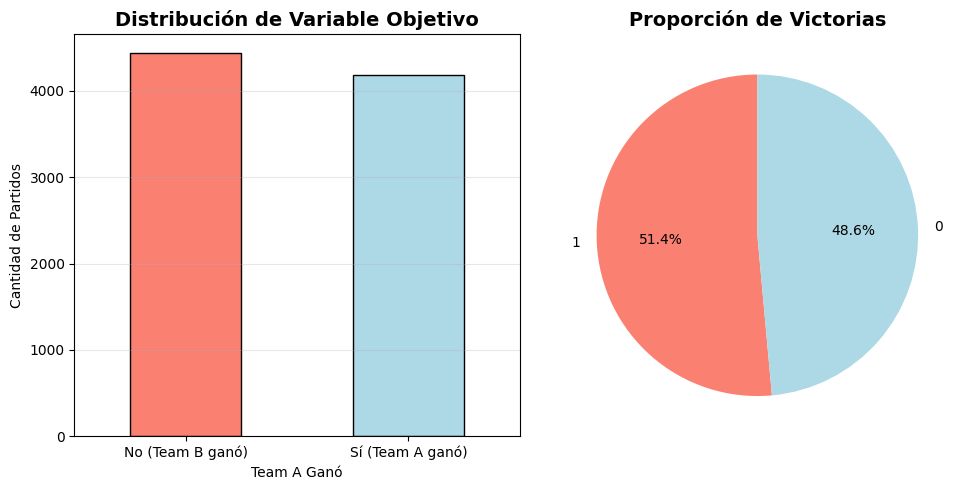

In [9]:
print("Limpiando duplicados")
print("="*60)

# Vemos duplicados
duplicates = df_wide_with_winner['Match Name'].duplicated().sum()
print(f"\n Filas duplicadas: {duplicates:,}")

# Eliminamos duplicados 
df_wide_clean = df_wide_with_winner.drop_duplicates(subset = 'Match Name', keep = 'first').copy()

print("\n Duplicados eliminados")
print(f"- Antes: {len(df_wide_with_winner):,} filas")
print(f"- Despues: {len(df_wide_clean):,} filas")

print("\n Creando variable objetivo")
print("="*60)

# Verificar que Team A y teamA_name coincidan
matches_check = (df_wide_clean['Team A'] == df_wide_clean['teamA_name']).sum()
print(f"\nVerificación: {matches_check:,}/{len(df_wide_clean):,} partidos tienen Team A == teamA_name")

# Crear variable binaria: teamA_won
# Si Match Result contiene el nombre de teamA, entonces teamA ganó
df_wide_clean['teamA_won'] = df_wide_clean.apply(lambda row: 1 if row['teamA_name'] in row['Match Result'] else 0, axis = 1)
print("\n Variable 'teamA_won' creada")
print("- 1 = Team A ganó")
print("- 0 = Team B ganó")

print("\n Distribución:")
teamA_wins = df_wide_clean['teamA_won'].sum()
teamB_wins = len(df_wide_clean) - teamA_wins

print(f"- Team A victorias: {teamA_wins:,} ({teamA_wins/len(df_wide_clean)*100:.1f}%)")
print(f"- Team B victorias: {teamB_wins:,} ({teamB_wins/len(df_wide_clean)*100:.1f}%)")


# Balance
if 0.45 <= (teamA_wins/len(df_wide_clean)) <= 0.55:
    print("\nDataset BALANCEADO")
else:
    print("\nDataset ligeramente DESBALANCEADO")

# Ver ejemplos
print(f"\nEJEMPLOS:")
display(df_wide_clean[['Match Name', 'teamA_name', 'teamB_name', 'Match Result', 'teamA_won']].head(5))

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_wide_clean['teamA_won'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'], edgecolor='black')
plt.title('Distribución de Variable Objetivo', fontsize=14, fontweight='bold')
plt.xlabel('Team A Ganó')
plt.ylabel('Cantidad de Partidos')
plt.xticks([0, 1], ['No (Team B ganó)', 'Sí (Team A ganó)'], rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
df_wide_clean['teamA_won'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                                 colors=['salmon', 'lightblue'],
                                                 startangle=90)
plt.title('Proporción de Victorias', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

- No importa que Team A tenga 200 kills
- Lo que importa es que Team A tenga MÁS kills que Team B
- diff_kills = teamA_kills - teamB_kills

In [11]:
# Creamos features diferrenciales (Team A - Team B)
print("Creando features diferenciales")
print("="*60)

# Stats a comparar
stats = ['kills', 'deaths', 'assists', 'acs', 'rating', 'first_kills', 'first_deaths', 'kd', 'ka', 'fkfd_diff']
print("\n Creando features...")

for stat in stats:
    col_a = f'teamA_{stat}'
    col_b = f'teamB_{stat}'

    if col_a in df_wide_clean.columns and col_b in df_wide_clean.columns:
        # Diferencia: A - B
        df_wide_clean[f'diff_{stat}'] = df_wide_clean[col_a] - df_wide_clean[col_b]
        print(f'diff_{stat}')

print(f"\n Total de columnas ahora: {df_wide_clean.shape[1]}")
print("\n diff_kills > 0 -> Team A tuvo más kills")
print("\n diff_kills < 0 -> Team B tuvo más kills")
print(f"\nEJEMPLO - Primeras 3 filas con features diferenciales:")
diff_cols = [col for col in df_wide_clean.columns if col.startswith('diff_')]
display(df_wide_clean[['Match Name', 'teamA_name', 'teamB_name', 'teamA_won'] + diff_cols].head(3))

Creando features diferenciales

 Creando features...
diff_kills
diff_deaths
diff_assists
diff_acs
diff_rating
diff_first_kills
diff_first_deaths
diff_kd
diff_ka
diff_fkfd_diff

 Total de columnas ahora: 38

 diff_kills > 0 -> Team A tuvo más kills

 diff_kills < 0 -> Team B tuvo más kills

EJEMPLO - Primeras 3 filas con features diferenciales:


,Match Name,teamA_name,teamB_name,teamA_won,diff_kills,diff_deaths,diff_assists,diff_acs,diff_rating,diff_first_kills,diff_first_deaths,diff_kd,diff_ka,diff_fkfd_diff
0,+W party vs tyeasy,+W party,tyeasy,0,-43.0,43.0,-25.0,-42.8,NaN,-10.0,10.0,-0.656172,-0.957908,-20.0
1,01234 vs Sluper,1234,Sluper,1,103.0,-103.0,25.0,177.0,1.436,14.0,-14.0,4.332027,5.463166,28.0
2,0Zero vs AlphaQ,0Zero,AlphaQ,1,80.0,-80.0,43.0,117.6,1.108,17.0,-17.0,1.829282,2.778222,34.0


In [12]:
# Guardamos dataset para el final
print("Guardando dataset final")
print("="*60)

outputh_path = '../data/processed/model_ready_dataset.parquet'
df_wide_clean.to_parquet(outputh_path, index = True)
print(f'DataSet guardado en: {outputh_path}')



Guardando dataset final
DataSet guardado en: ../data/processed/model_ready_dataset.parquet
